# Análisis exploratorio de datos
Antes de comenzar a desarrollar los modelos de detección automática de idiomas, un paso fundamental es el análisis exploratorio de datos. Necesitamos conocer las características relevantes de nuestro conjunto de datos para nuestro problema de cara a poder llevar a cabo un preprocesamiento adecuado y elegir unos modelos u otros.

Analizaremos los siguientes aspectos:
- Distribución del número de muestras por idioma
- Distribución de la longitud de las frases por idioma (y global)
- Palabras más comunes por idioma
- Tamaño del vocabulario por idioma
- Palabras que aparecen en varios idiomas
- Conjunto mínimo de palabras por idioma que aparecen en todas las frases de ese idioma

In [13]:
# Librerías necesarias
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

## 0. Lectura del conjunto de datos
Comenzamos cargando el corjunto de datos que hemos creado previamente. Para evitar el "data leakeage" y simular el flujo de producción, realizaremos el EDA sobre el conjunto de entrenamiento.

In [14]:
df_train = pd.read_csv(os.path.join("data","raw","train.csv"))

In [15]:
df_train

,text,language,n_words
0,"Jeśli chcecie dziś się zbłaźnić, to zapraszam.\n",pl,7
1,Los hombres estaban en el frente por aquel ent...,es,9
2,"Ορθώς, επειδή η αρχική πρόταση απέβλεπε μόνο σ...",el,10
3,De modo que en ese sentido hay un claro equili...,es,10
4,V tem kontekstu moramo izpostaviti kmetijski s...,sl,7
...,...,...,...
41994,"Prav tako moramo jasno določiti, ali predlagan...",sl,13
41995,Νομίζω ότι αυτό είναι άδικο.\n,el,5
41996,Tämän lisäksi pyrkimykset Haitin valtion jälle...,fi,13
41997,"(FI) Κύριε Πρόεδρε, υπερψήφισα και εγώ το ψήφι...",el,14


Un comentario importante:\
Emplearemos la columna n_words para contabilizar el número de palabras como una primera aproximación. Esta columna se creó junto con el dataset y no solo contiene palabras, sino cualquier secuencia de letras separadas por "word boundaries" (por ejemplo Mr o Kg serían palabras). Para este análisis, consideraremos que representa el número de palabras.

## 1. Distribución del número de muestras por idioma
Comenzaremos analizando la distribución de la variable objetivo. Por construcción del dataset sabemos que tiene que estar balanceado, por lo que este análisis es una mera comprobación.

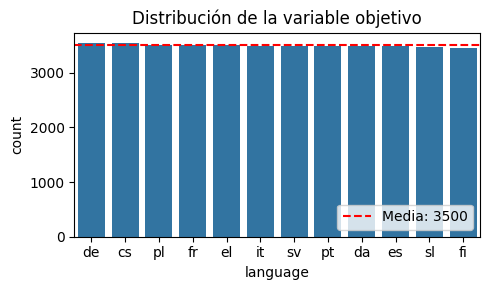

In [16]:
lan_counts = df_train["language"].value_counts()

# Plot
plt.figure(figsize=(5,3))
sns.barplot(lan_counts)
plt.title("Distribución de la variable objetivo")

# Añadimos la media
mean_count = lan_counts.mean()
plt.axhline(mean_count, color='red', linestyle='--', label=f"Media: {mean_count:.0f}")

# Mostrar leyenda
plt.legend(loc='lower right')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Se comprueba lo que ya sabíamos, tenemos un dataset balanceado

## 2. Distribución de la longitud de las frases
Veamos ahora la longitud de las frases según el idioma

In [17]:
# Breve resumen global
df_train["n_words"].describe()

count    41999.000000
mean        10.025620
std          3.516841
min          2.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         15.000000
Name: n_words, dtype: float64

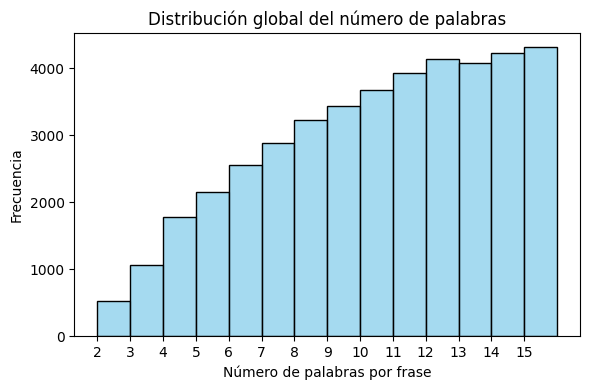

In [18]:
# Gráfico
min_words = df_train["n_words"].min()
max_words = df_train["n_words"].max()

plt.figure(figsize=(6, 4))
sns.histplot(df_train["n_words"], bins=range(min_words, max_words + 2), kde=False, color='skyblue')

plt.title("Distribución global del número de palabras")
plt.xlabel("Número de palabras por frase")
plt.ylabel("Frecuencia")
plt.xticks(range(min_words, max_words + 1))
plt.tight_layout()
plt.show()

Vemos que predominan las frases más largas, lo cual es de esperar al ser intervenciones parlamentarias. Veamos ejemplos de frases de 2 palabras:

In [19]:
# Ejemplos de frases con 2 palabras
df_train[df_train["n_words"]==2].head(7)

,text,language,n_words
6,. – Herr Präsident!\n,de,2
123,""" συζήτηση έληξε.\n",el,2
230,Muchas gracias.\n,es,2
323,Llevamos retraso.\n,es,2
373,Dziękuję bardzo.\n,pl,2
416,¿Por qué?\n,es,2
583,Mme Belohorská.\n,fr,2


Veamos la distribución del número de palabras por idioma

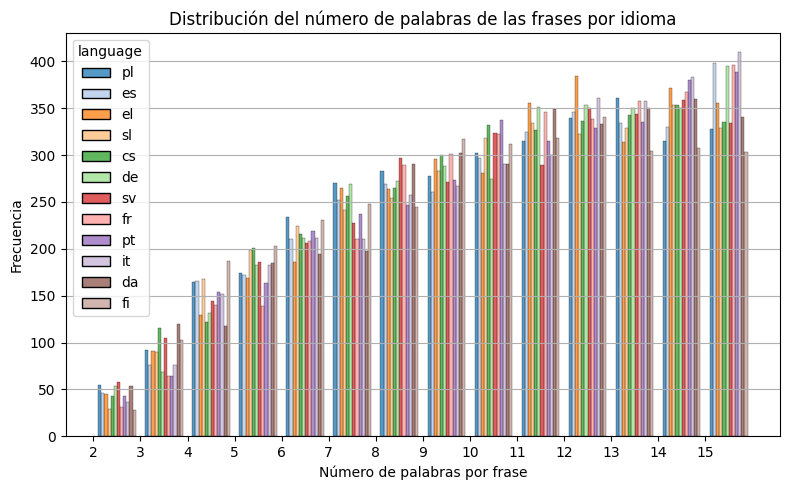

In [20]:
min_words = df_train["n_words"].min()
max_words = df_train["n_words"].max()

plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_train,
    x="n_words",
    bins=range(min_words, max_words + 2),
    hue="language",
    multiple="dodge",   # También puedes probar "dodge" para barras lado a lado
    palette="tab20",
    shrink=0.8
)

plt.title("Distribución del número de palabras de las frases por idioma")
plt.xlabel("Número de palabras por frase")
plt.ylabel("Frecuencia")
plt.xticks(range(min_words, max_words + 1))
plt.tight_layout()
plt.grid(axis="y")
plt.show()

In [21]:
# Resumen estadístico
print(df_train
 .groupby("language")["n_words"]
 .describe()
 .round(2))

           count   mean   std  min  25%   50%   75%   max
language                                                 
cs        3546.0   9.93  3.51  2.0  7.0  10.0  13.0  15.0
da        3487.0  10.01  3.54  2.0  8.0  10.0  13.0  15.0
de        3551.0  10.11  3.51  2.0  7.0  11.0  13.0  15.0
el        3508.0  10.10  3.48  2.0  7.0  11.0  13.0  15.0
es        3482.0  10.05  3.55  2.0  7.0  10.0  13.0  15.0
fi        3448.0   9.74  3.51  2.0  7.0  10.0  13.0  15.0
fr        3512.0  10.28  3.41  2.0  8.0  11.0  13.0  15.0
it        3496.0  10.22  3.54  2.0  8.0  11.0  13.0  15.0
pl        3512.0   9.84  3.54  2.0  7.0  10.0  13.0  15.0
pt        3487.0  10.16  3.50  2.0  7.0  11.0  13.0  15.0
sl        3475.0   9.93  3.51  2.0  7.0  10.0  13.0  15.0
sv        3495.0   9.93  3.56  2.0  7.0  10.0  13.0  15.0


Vemos distribuciones muy similares entre los idiomas, lo cual era de esperar ya que al construir el dataset hemos filtrado por longitud para construir un dataset homogéneo.

## 3. Palabras más comunes por idioma
Veamos las palabras más comunes de cada idioma

**OBSERVACIÓN: NO DISTINGUIREMOS ENTRE MAYÚSCULAS y MINÚSCULAS**. Aunque es cierto que el uso de mayúsculas es un signo distintivo de algunos idiomas como el alemán, en la mayoría de idiomas considerados no lo es. Además, nosotros podríamos diferenciar en la mayoría de los casos frases en alemán aunque no estén escritas con las mayúsculas correspondientes. El principal motivo para no distinguir entre mayúsculas y minúsculas es no aumentar el vocabulario innecesariamente añadiendo palabras duplicadas con y sin la mayúscula inicial. Por otro lado, de cara a la puesta en producción del sistema hay muchos casos en los que nos interesa no diferenciar entre mayúsculas y minúsculas —muchas veces los usuarios escriben rápido y emplean las mayúsculas en un contexto informal—. En función de la que fuese la aplicación final de este sistema, esta decisión podría cambiar.

In [22]:
from collections import Counter

# Creemos los vocabularios y los contadores de palabras de cada idioma
vocabularies = {}
word_counters = {}

# Creamos una nueva columna en df_train donde separaremos las palabras y pasaremos todo a minúscula
df_train["words"] = df_train["words"] = df_train["text"].apply(
    lambda s: [w.lower() for w in re.findall(r'\b[^\W\d_]+\b', s, flags=re.UNICODE)]
)

for lan in df_train["language"].unique():
    df_lan = df_train[df_train["language"]==lan]

    # Creamos el vocabulario
    vocabularies[lan] = set(word
                         for word_list in df_lan["words"]
                         for word in word_list)
    # Creamos un contador de palabras
    word_counters[lan] = Counter(word
                                 for words_list in df_lan["words"]        
                                 for word in words_list)    

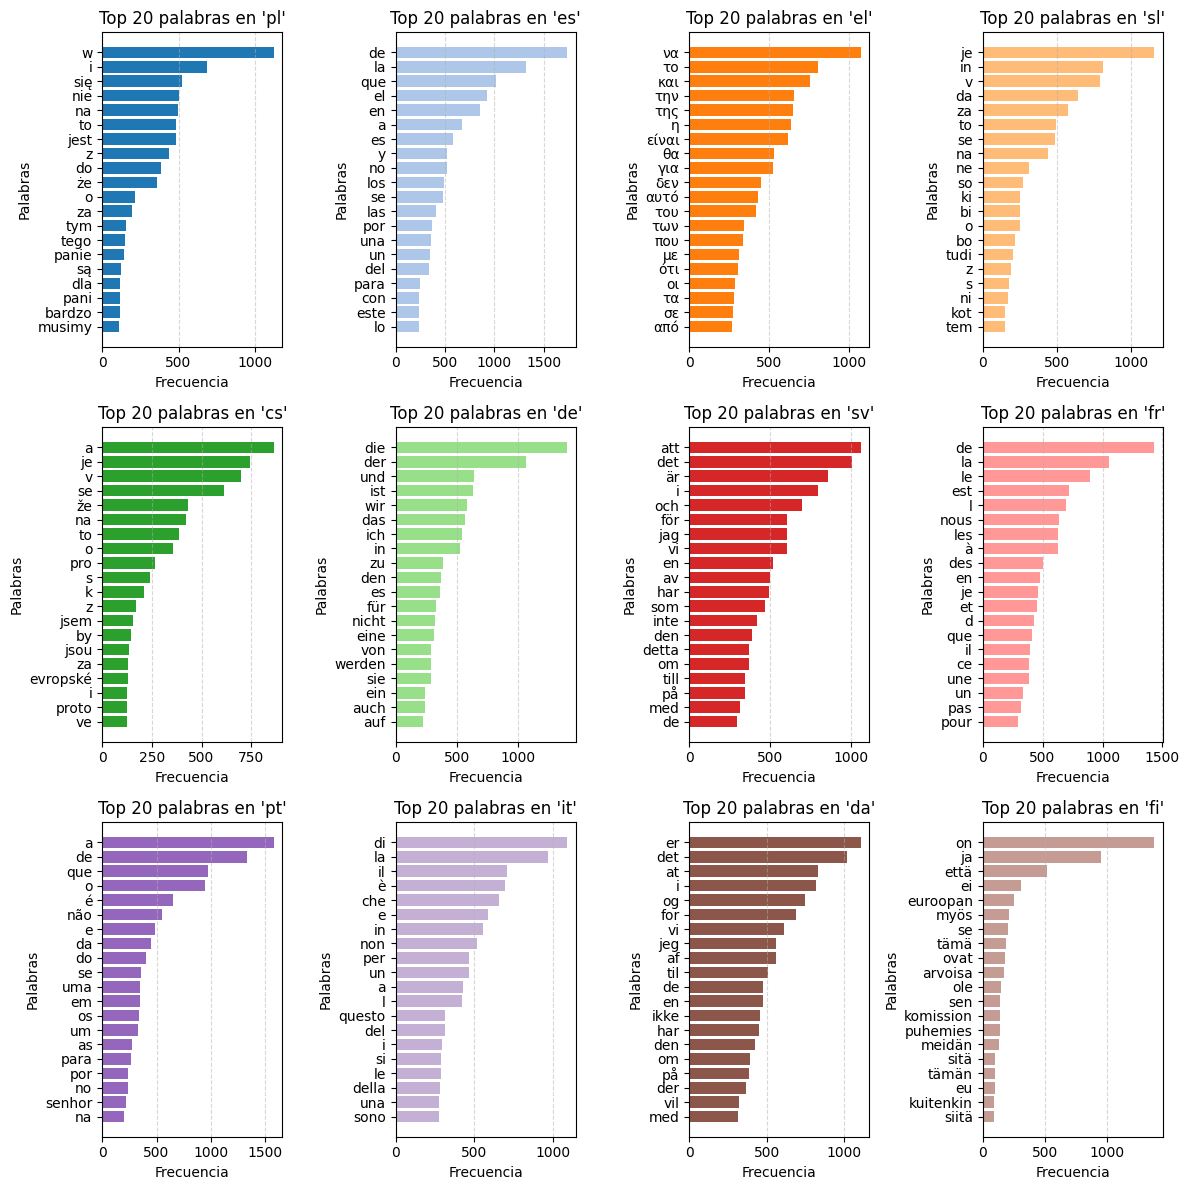

In [23]:
n_most_freq = 20  # Número de palabras más frecuentes a mostrar

# Plots
n_cols = 4  # Número de columnas 
n_langs = df_train["language"].nunique() # Número de idiomas
n_rows = (n_langs + n_cols - 1) // n_cols  # Calcula el número de filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3* n_cols, 4 * n_rows))
axes = axes.flatten()  # Aplanamos para acceso fácil

# Para seguir con la paleta de colores anterior
colors = sns.color_palette("tab20")


for i, lan in enumerate(df_train["language"].unique()):
    most_freq = word_counters[lan].most_common(n_most_freq)
    top_words, top_freq = zip(*most_freq)
    
    ax = axes[i]
    ax.barh(top_words[::-1], top_freq[::-1], color=colors[i])
    ax.set_title(f"Top {n_most_freq} palabras en '{lan}'")
    ax.set_xlabel("Frecuencia")
    ax.set_ylabel("Palabras")
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


Como era de esperar las palabras más frecuentes en todos los idiomas son palabras con más contenido gramatical que semántico (pronombres, preprosiciones, artículos...), son lo que se conocen como "stop words". En muchas tareas de PLN se eliminan, pues no tienen un contenido semántico importante. Sin embargo, en esta tarea serán claves para detectar el idioma.

Lo primero que nos salta a la vista es que tenemos (al menos) dos alfabetos: el latino y el griego. Además, entre las lenguas que emplean el alfabeto latinos encontramos diferencias, ya que algunos idiomas añaden nuevas letras a este: el alemán, el danés, el finés, ... Otro aspecto que diferencia visualmente los idiomas es el uso de acentos, tenemos idiomas que los usan —como las lenguas romance— e idiomas que no —como el finés y el danés—.

También vemos que hay palabras compartidas entre distintos idiomas:
- "a" aparece en español, italiano y portugués
- "es" aparece en español, alemán
- "se" aparece en español, esloveno
- ...

Veámoslas con más detalle

## 4. Tamaño del vocabulario por idioma
Veamos el tamaño del vocabulario de cada idioma

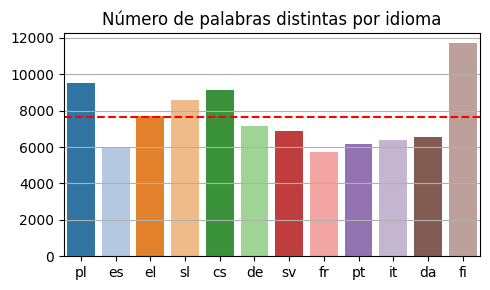

In [31]:
# Vemos el número de palabras por idioma
langs = df_train["language"].unique()
vocab_sizes = []
for lan in langs:
    vocab_sizes.append(len(vocabularies[lan]))

# Plot
plt.figure(figsize=(5,3))
sns.barplot(x=langs,y=vocab_sizes,palette="tab20",hue=langs, legend=False)
plt.title("Número de palabras distintas por idioma")

# Añadimos la media
mean_size = np.mean(vocab_sizes)
plt.axhline(mean_size, color='red', linestyle='--')

# Mostrar la gráfica
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Vemos que en nuestro corpus, los idiomas con un vocabulario más amplio son el finés, el polaco, el checo y el eslovaco.

## 5. Palabras que aparecen en más de un idioma

In [25]:
from collections import defaultdict

# Diccionario para contar en cuántos idiomas aparece cada palabra
word_lang_count = defaultdict(set)

# Llenamos el diccionario con sets de idiomas por palabra
for lang, vocab in vocabularies.items():
    for word in vocab:
        word_lang_count[word].add(lang)

# Filtramos las palabras que aparecen en más de un idioma
shared_words = {word: langs for word, langs in word_lang_count.items() if len(langs) > 1}

# Resultado: palabra -> número de idiomas donde aparece
shared_words_counts = {word: len(langs) for word, langs in shared_words.items()}

# Ordenar por número de idiomas (de mayor a menor)
shared_words_counts = dict(sorted(shared_words_counts.items(), key=lambda x: x[1], reverse=True))

# Mostrar algunas palabras y en cuántos idiomas aparecen
for word, count in list(shared_words_counts.items())[:50]:
    print(f"Palabra '{word}' aparece en {count} idiomas: {shared_words[word]}")


Palabra 'de' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'schulz' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'fr' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'pl' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'barroso' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'hu' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'ppe' aparece en 12 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'es' aparece en 11 idiomas: {'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi', 'el'}
Palabra 'a' aparece en 11 idiomas: {'pt', 'da', 'es', 'sl', 'fr', 'de', 'pl', 'cs', 'sv', 'it', 'fi'}
Palabra 'nl' aparece e

In [26]:
print(f"Hay {len(shared_words)} palabras que aparecen en varios idiomas")

Hay 3904 palabras que aparecen en varios idiomas


Podemos observar varios tipos de términos que aparecen en varios idiomas:
Claro, aquí tienes el texto ligeramente enriquecido y organizado para que sea más claro y directo:

Además de palabras comunes o funcionales, observamos en el corpus una notable presencia de:

- **Nombres propios de personas**, que aparecen en múltiples idiomas:\
*barroso*, *schulz*, *crowley*, *swoboda*, *solana*, *galileo*, *kinnock*, *verheugen*, *ruijten*, *oomen*...

- **Nombres de países o sus códigos**, que aparecen tanto en las intervenciones como en las acotaciones:\
*iran*, *fr* (Francia), *pl* (Polonia), *es* (España), *nl* (Países Bajos), *ro* (Rumanía), *pt* (Portugal), *hu* (Hungría), *it* (Italia), *de* (Alemania), *lv* (Letonia)...

- **Abreviaturas políticas o institucionales**, que también suelen aparecer en las acotaciones:\
*ppe* (Partido Popular Europeo), *pse*, *alde*, *eu* (Unión Europea), *usa*, *sv* (Suecia), *cs* (Chequia), *el* (Grecia)...

- **Términos comunes en debates europeos**:\
*euro*, *internet*, *agenda*, *reach*, *schengen*, *galileo*...

- **Artículos o preposiciones frecuentes** en varios idiomas:\
*de*, *a*, *en*, *el*, *le*, *o*, *e*, *i*, *da*...

**OBSERVACIÓN:** Los códigos de países, los nombres de persona y las abreviaturas comunes en la UE podrían eliminarse de nuestro corpus para mejorar su calidad. Sin embargo, al encontrarse en muchos idiomas esperamos que estas palabras no tengan peso a la hora de indicar un idioma u otro. 

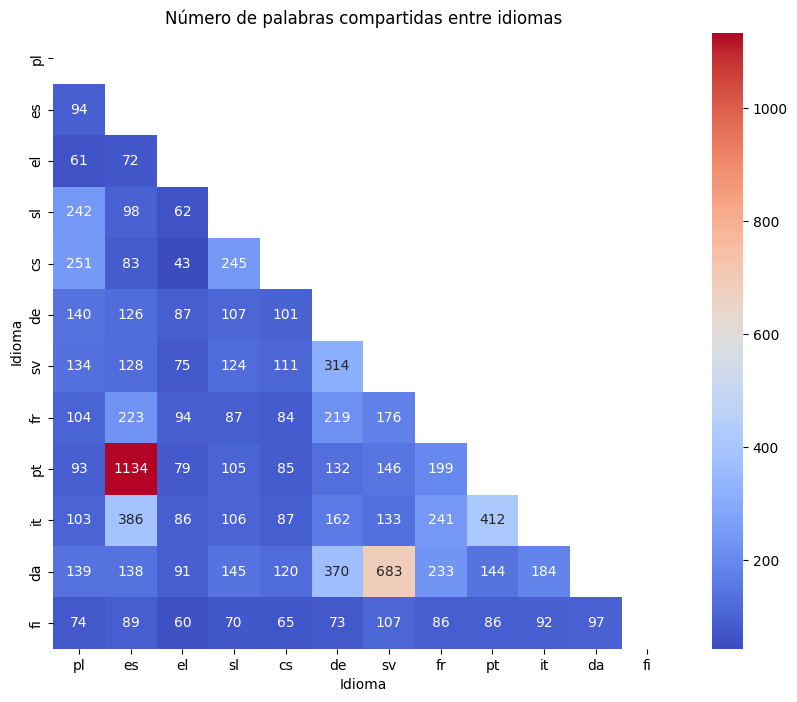

In [29]:
langs = list(vocabularies.keys())
n_langs = len(langs)

# Crear DataFrame vacío
shared_words_matrix = pd.DataFrame(index=langs, columns=langs, dtype=int)

# Rellenar matriz con conteo de palabras compartidas
for i in range(n_langs):
    for j in range(n_langs):
        shared = vocabularies[langs[i]].intersection(vocabularies[langs[j]])
        shared_words_matrix.iloc[i, j] = len(shared)
    # shared_words_matrix.iloc[i,i] = 0

shared_words_matrix = shared_words_matrix.fillna(0).astype(int)

mask = np.triu(np.ones_like(shared_words_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(shared_words_matrix, annot=True, fmt="d", cmap="coolwarm", mask=mask)
plt.title("Número de palabras compartidas entre idiomas")
plt.xlabel("Idioma")
plt.ylabel("Idioma")
plt.show()

Los idiomas que más se parecen entre sí al comparar sus vocabularios son el español y el portugués, que comparten 1134 "palabras". Seguidamente, y para mi sorpresa, se encuentran el danés y el sueco, con 683 términos en común. A continuación de estos encontramos el portugués y el italiano con 412, español y el italiano con 386 y el danés y el alemán con 370.

## Palabras que aparecen en todas las frases de un idioma
Veamos si para algún idioma hay palabras que aparezcan en todas las frases

In [28]:
words_in_all_sentences = {}

for lan in langs:
    df_lan = df_train[df_train["language"] == lan]

    # Convertimos cada lista de palabras en un set y las acumulamos en una lista
    sentence_sets = [set(words) for words in df_lan["words"]]

    # Intersección de todos los sets (palabras comunes a todas las frases)
    if sentence_sets:
        common_words = set.intersection(*sentence_sets)
    else:
        common_words = set()  # por si no hay frases

    words_in_all_sentences[lan] = common_words

words_in_all_sentences


{'pl': set(),
 'es': set(),
 'el': set(),
 'sl': set(),
 'cs': set(),
 'de': set(),
 'sv': set(),
 'fr': set(),
 'pt': set(),
 'it': set(),
 'da': set(),
 'fi': set()}

Como cabía esperar, no las hay. Veamos si limitándonos a las frases más largas sí tenemos palabras recurrentes:

In [29]:
words_in_all_sentences = {}

for lan in langs:
    df_lan = df_train[df_train["language"] == lan]

    # Convertimos cada lista de palabras en un set y las acumulamos en una lista
    sentence_sets = [set(words) for words in df_lan["words"] if len(words)>=15]

    # Intersección de todos los sets (palabras comunes a todas las frases)
    if sentence_sets:
        common_words = set.intersection(*sentence_sets)
    else:
        common_words = set()  # por si no hay frases

    words_in_all_sentences[lan] = common_words

words_in_all_sentences


{'pl': set(),
 'es': set(),
 'el': set(),
 'sl': set(),
 'cs': set(),
 'de': set(),
 'sv': set(),
 'fr': set(),
 'pt': set(),
 'it': set(),
 'da': set(),
 'fi': set()}

Tampoco